In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '289387'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

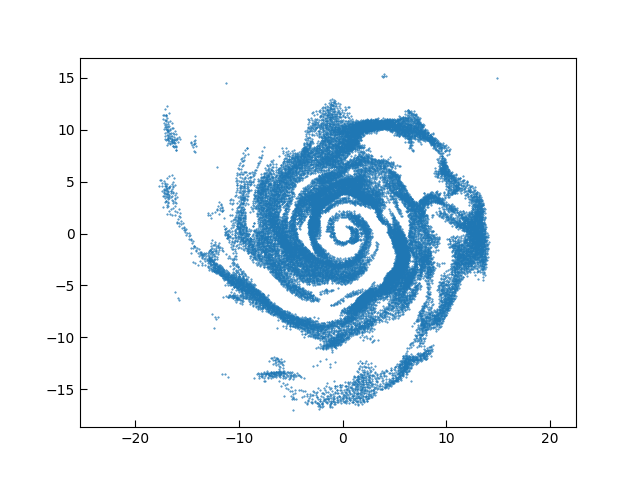

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


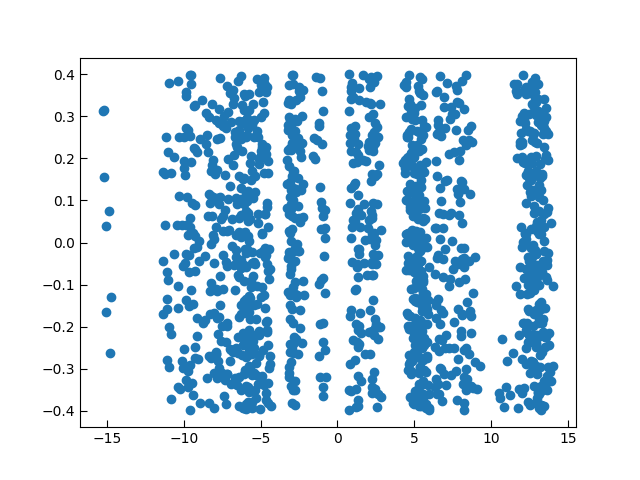

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


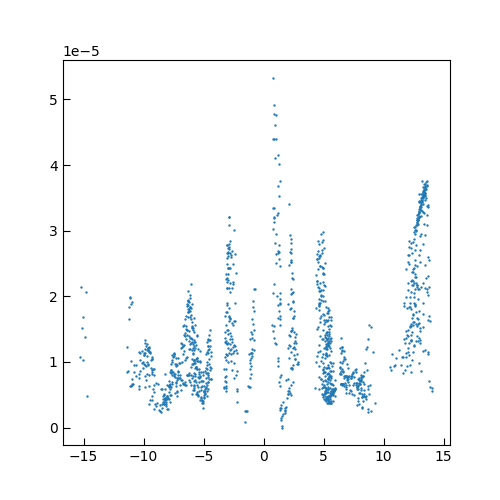

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

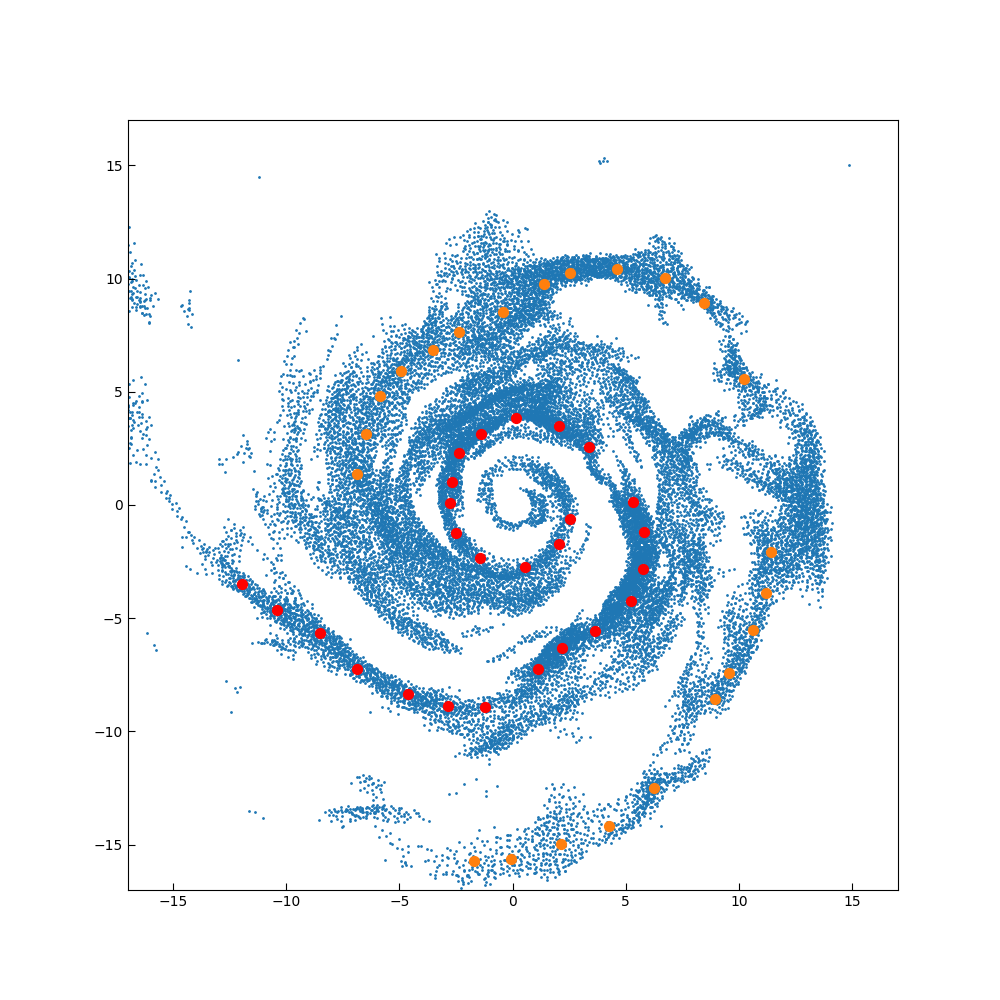

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 17
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [12]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [13]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [14]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [15]:
b = 0.3

In [16]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

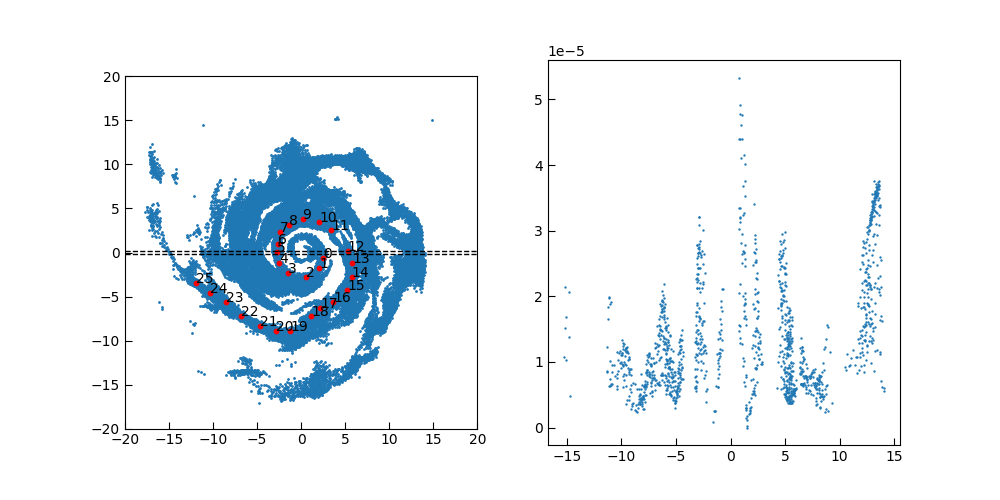

In [17]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

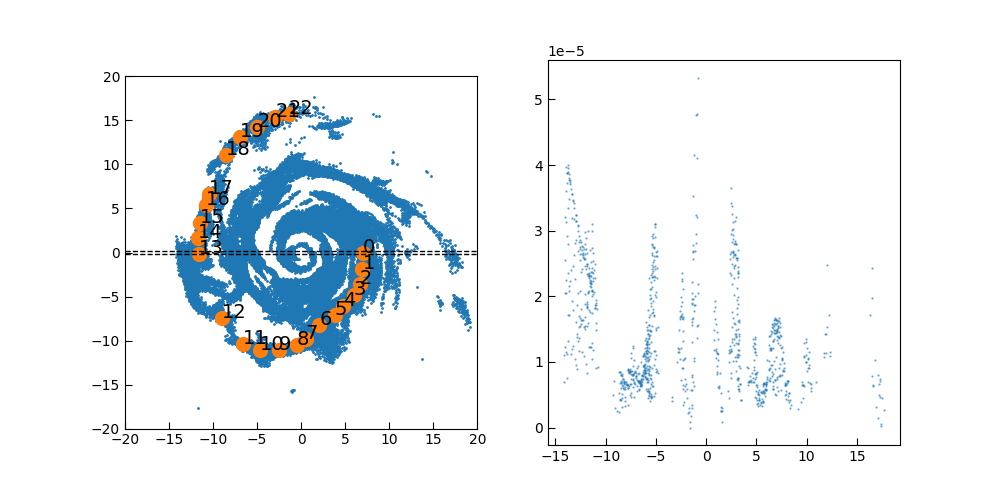

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [19]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [20]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [21]:
arm = df_arm2.copy(deep=True)

In [22]:
arm.head()

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-6.875902,1.351010,2,0,"({'x_rot': [-0.32096450970059015, -0.202413614...","{'x_rot': [-0.32096450970059015, -0.2024136145...",2.947579,"{'x_rot': [7.00737146867941, 6.955889916379408...","{'x_rot': 7.00737146867941, 'y_rot': 1.3322676...","{'x_band': [-0.780245289395165, 0.812904863411..."
1,-6.471861,3.140332,2,1,"({'x_rot': [-0.12416785781555334, 0.0054255352...","{'x_rot': [-0.12416785781555334, 0.00542553525...",2.689832,"{'x_rot': [6.775894179838164, 7.19351619810509...","{'x_rot': 7.193516198105094, 'y_rot': 4.440892...","{'x_band': [-0.9537736318955385, -1.1071422906..."
2,-5.836941,4.814214,2,2,"({'x_rot': [0.06507168780532085, 0.19726623785...","{'x_rot': [0.06507168780532085, 0.197266237859...",2.451921,"{'x_rot': [6.164075838076206, 6.99089297743850...","{'x_rot': 7.5661437057331575, 'y_rot': -4.4408...","{'x_band': [-0.764740875109768, -1.14816468232..."
3,-4.913420,5.910895,2,3,"({'x_rot': [0.21225019976167042, 0.34123656100...","{'x_rot': [0.21225019976167042, 0.341236561007...",2.264303,"{'x_rot': [5.434274017674478, 6.55200138530835...","{'x_rot': 7.686375669831936, 'y_rot': 2.220446...","{'x_band': [-0.799950871178112, -1.14061703211..."
4,-3.528139,6.834416,2,4,"({'x_rot': [0.37283256845056495, 0.49248019383...","{'x_rot': [0.37283256845056495, 0.492480193833...",2.047344,"{'x_rot': [4.35456209303642, 5.759184956212291...","{'x_rot': 7.6913586481348055, 'y_rot': 0.0}","{'x_band': [-0.8056315277544868, -0.8652855973..."


(-2.5, 2.5)

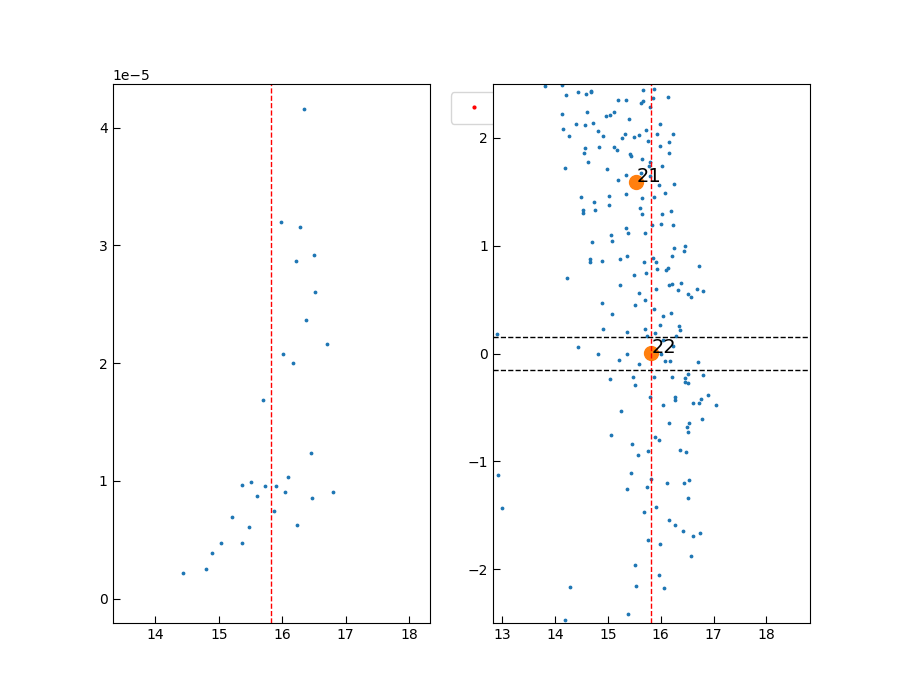

In [300]:
%matplotlib widget

n= 22 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(9,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2.5,x_tracing+2.5)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [301]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [302]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(1.2571585610007082e-20, 2.876587801501408e-05)

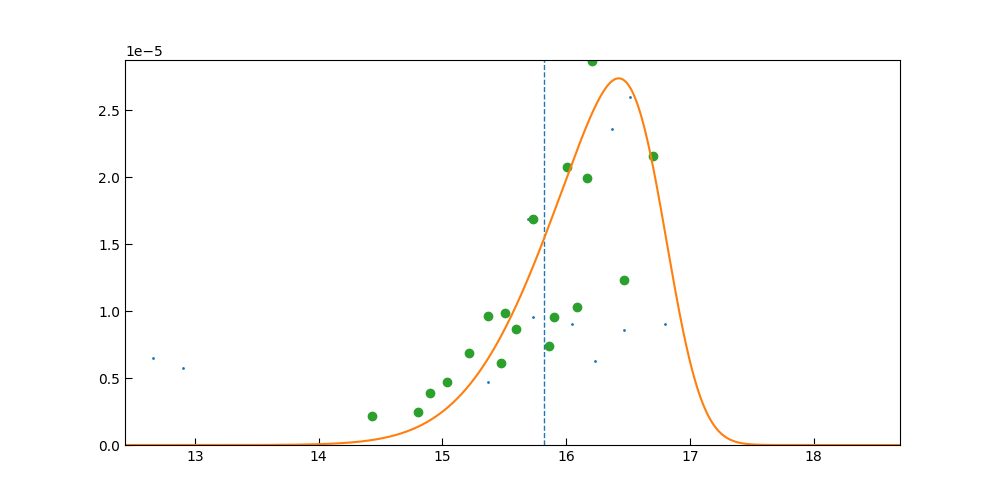

In [303]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [304]:
fractured = False

In [305]:
df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [306]:
df_params.tail(2)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
21,0.000029,16.264644,0.05,False,-5640.976384,21.0,0.614311,0.000014,0.325611,8.785424e+07,0.190907,"[14.295908601337684, 14.582195710904342, 14.72...",-0.064935,"[1.6928854359250075e-06, 1.6902784545877e-06, ...",-15.618687
22,0.000032,16.790081,0.05,False,-3.174663,22.0,0.787664,0.000009,0.186238,5.582086e+00,0.169820,"[14.435743520439695, 14.804620649288717, 14.89...",-1.681097,"[2.1380658943154224e-06, 2.4995823994512627e-0...",-15.734127


In [307]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [308]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000034,7.544319,0.05,False,-1.280062,0.0,1.081211,6.972993e-07,0.106043,3.835790e-01,0.101112,"[5.457891563686297, 5.470596675078455, 5.54258...",-6.875902,"[5.41416225299757e-06, 5.387739580185315e-06, ...",1.351010
1,0.000018,8.253373,0.05,False,-2.827778,1.0,1.380712,2.652489e-06,0.132261,2.284118e+00,0.464090,"[6.774606195071674, 6.823430618004306, 6.87792...",-6.471861,"[5.935527983386941e-06, 6.268813783770811e-06,...",3.140332
2,0.000039,9.136066,0.05,False,-2.028356,2.0,2.180747,3.122419e-06,0.295650,1.479713e+00,0.567550,"[6.007992575552287, 6.134654479444803, 6.24016...",-5.836941,"[5.2367944488047285e-06, 7.2925853827430656e-0...",4.814214
3,0.000026,7.155127,0.05,False,1.374919,3.0,0.988382,1.407120e-06,0.225317,1.033417e+00,0.234588,"[6.4485148370387595, 6.592857856913558, 6.6862...",-4.913420,"[5.370831503999407e-06, 5.7365966436352434e-06...",5.910895
4,0.000035,8.593441,0.05,False,-2.371188,4.0,1.220056,2.057815e-06,0.099616,1.100683e+00,0.180138,"[6.456139518559294, 6.524453580779504, 6.58566...",-3.528139,"[6.432191904198475e-06, 6.686914505931648e-06,...",6.834416
5,0.000039,7.728465,0.05,False,-0.009802,5.0,1.566642,5.853086e-06,36578.998429,2.926663e+04,285.317344,"[6.451052662844727, 6.51147145483096, 6.605995...",-2.373737,"[7.561294770758457e-06, 7.627253711475477e-06,...",7.642496
6,0.000028,7.098618,0.05,False,1.831339,6.0,1.499379,2.057730e-06,0.261015,1.610192e+00,0.411218,"[6.806825358472618, 6.856236008122611, 6.91393...",-0.411255,"[6.959905177137098e-06, 4.580104375908619e-06,...",8.508297
7,0.000042,10.983673,0.05,False,-5.929829,7.0,1.756504,1.941906e-06,0.057256,2.371350e+00,0.103258,"[7.95171507844039, 8.136686961899203, 8.170194...",1.378066,"[1.8173322908285384e-06, 5.302862641731914e-06...",9.778139
8,0.000039,10.107006,0.05,False,13.099572,8.0,1.103819,2.392408e-06,0.012739,3.482547e+00,0.093801,"[9.746384207132563, 9.985573320081889, 10.0406...",2.532468,"[5.312915570128685e-06, 6.292953665209765e-06,...",10.239899
9,0.000043,11.536088,0.05,False,0.000222,9.0,0.765785,5.643822e-06,270951.247861,4.434567e+05,601.227917,"[10.949505618741565, 10.99445285099674, 11.030...",4.610390,"[1.6286134984146862e-05, 1.7279966088721434e-0...",10.413059


In [309]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [310]:
arm.iloc[n].id

22

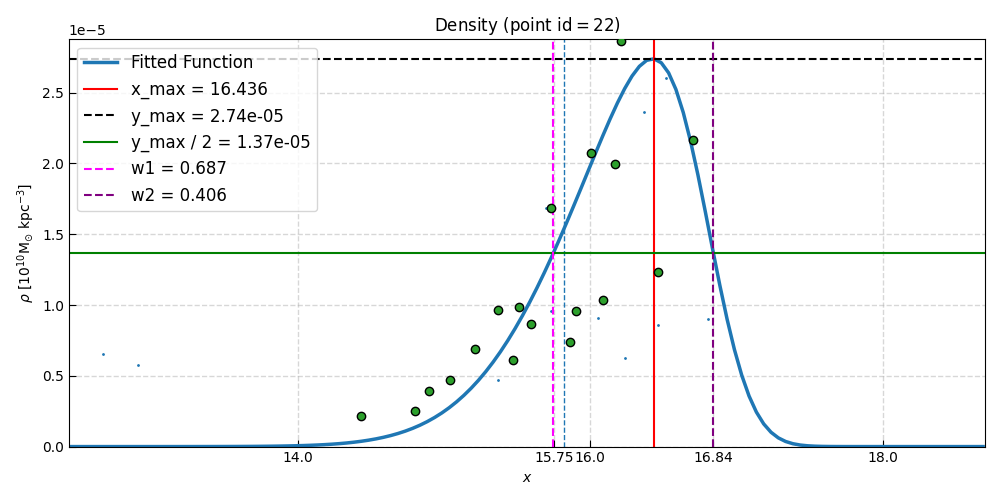

In [311]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

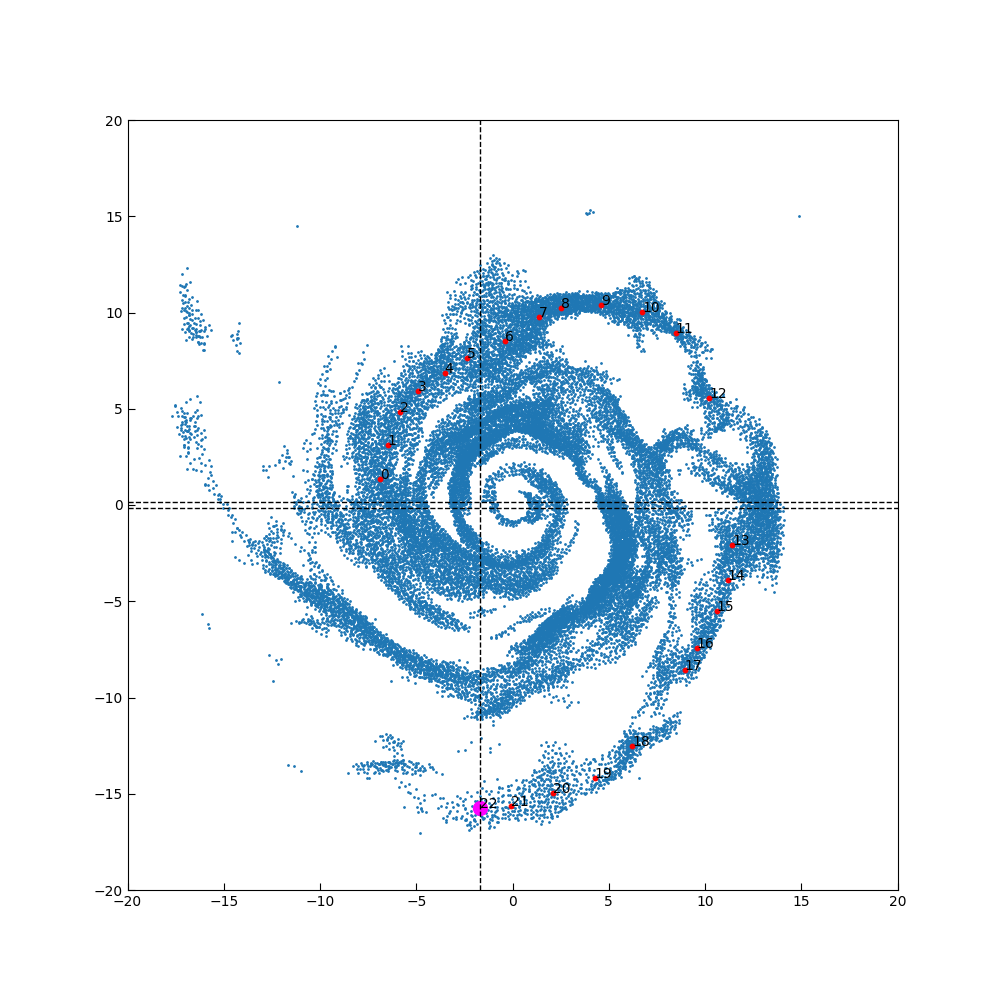

In [312]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [313]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [314]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

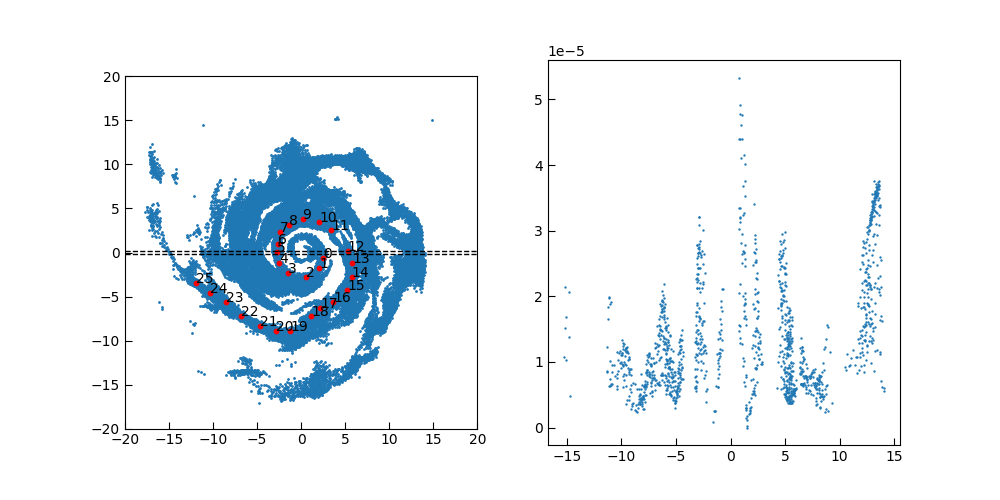

In [315]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [316]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [317]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,2.532468,-0.611472,1,0,"({'x_rot': [0.28933868388511974, 0.16837983421...","{'x_rot': [0.28933868388511974, 0.168379834212...",6.046267,"{'x_rot': [2.6052427219693124, 2.4137811965802...","{'x_rot': 2.6052427219693124, 'y_rot': 1.44328...","{'x_band': [0.76886343665385, -0.8068114889049..."
1,2.070707,-1.708153,1,1,"({'x_rot': [-0.06513283257373159, -0.197327016...","{'x_rot': [-0.06513283257373159, -0.1973270160...",5.593437,"{'x_rot': [2.3426671369080596, 2.6843275323855...","{'x_rot': 2.684327532385526, 'y_rot': -2.22044...","{'x_band': [0.7647609206378505, 1.148169873796..."
2,0.569986,-2.747114,1,2,"({'x_rot': [-0.5486140886838646, -0.6487098291...","{'x_rot': [-0.5486140886838646, -0.64870982918...",4.916971,"{'x_rot': [1.1132119917570147, 2.0932123206140...","{'x_rot': 2.805622722878369, 'y_rot': 1.110223...","{'x_band': [0.7785254089032712, 0.759540443558..."
3,-1.450216,-2.343074,1,3,"({'x_rot': [-0.7967030850584758, -0.8098342117...","{'x_rot': [-0.7967030850584758, -0.80983421173...",4.158161,"{'x_rot': [-0.8128659601993202, 0.362668179039...","{'x_rot': 2.755561941789224, 'y_rot': 0.0}","{'x_band': [-0.7967030850584758, -0.8098342117..."
4,-2.489177,-1.246392,1,4,"({'x_rot': [-0.7007408125601368, -0.6428570634...","{'x_rot': [-0.7007408125601368, -0.64285706342...",3.605820,"{'x_rot': [-1.9906756331078168, -1.08676518077...","{'x_rot': 2.783792166755894, 'y_rot': 8.881784...","{'x_band': [-0.8200150541088961, -0.8394739872..."
5,-2.777778,0.081169,1,5,"({'x_rot': [-0.4364504525057702, -0.3291331876...","{'x_rot': [-0.4364504525057702, -0.32913318763...",3.112380,"{'x_rot': [-2.5492471066127393, -2.11971586039...","{'x_rot': 2.778963432985283, 'y_rot': 7.771561...","{'x_band': [-0.7970981377735858, -0.8602231828..."
6,-2.662338,1.004690,1,6,"({'x_rot': [-0.1952080711245847, -0.0685581048...","{'x_rot': [-0.1952080711245847, -0.06855810488...",2.780745,"{'x_rot': [-2.585261948541223, -2.540442587053...","{'x_rot': 2.8456006978281603, 'y_rot': 0.0}","{'x_band': [-0.9404099894182705, 0.78092303262..."
7,-2.373737,2.274531,1,7,"({'x_rot': [0.12399003082657595, 0.25546504476...","{'x_rot': [0.12399003082657595, 0.255465044760...",2.377534,"{'x_rot': [-2.251578880666341, -2.676919437404...","{'x_rot': 3.287570607763694, 'y_rot': 4.440892...","{'x_band': [-0.7820027500248318, -1.1500104447..."
8,-1.392496,3.140332,1,8,"({'x_rot': [0.4138981702229187, 0.529999915931...","{'x_rot': [0.4138981702229187, 0.5299999159318...",1.988168,"{'x_rot': [-1.5855397450346183, -2.40090049052...","{'x_rot': 3.435219146510295, 'y_rot': 0.0}","{'x_band': [-0.8005930091861059, -0.8652245873..."
9,0.165945,3.832973,1,9,"({'x_rot': [0.6739655751126205, 0.749787167933...","{'x_rot': [0.6739655751126205, 0.7497871679334...",1.527529,"{'x_rot': [-0.5013612632385553, -1.61698880583...","{'x_rot': 3.8365631260178765, 'y_rot': -2.7755...","{'x_band': [-0.8193913763680317, -0.7802877162..."


(-2.5, 2.5)

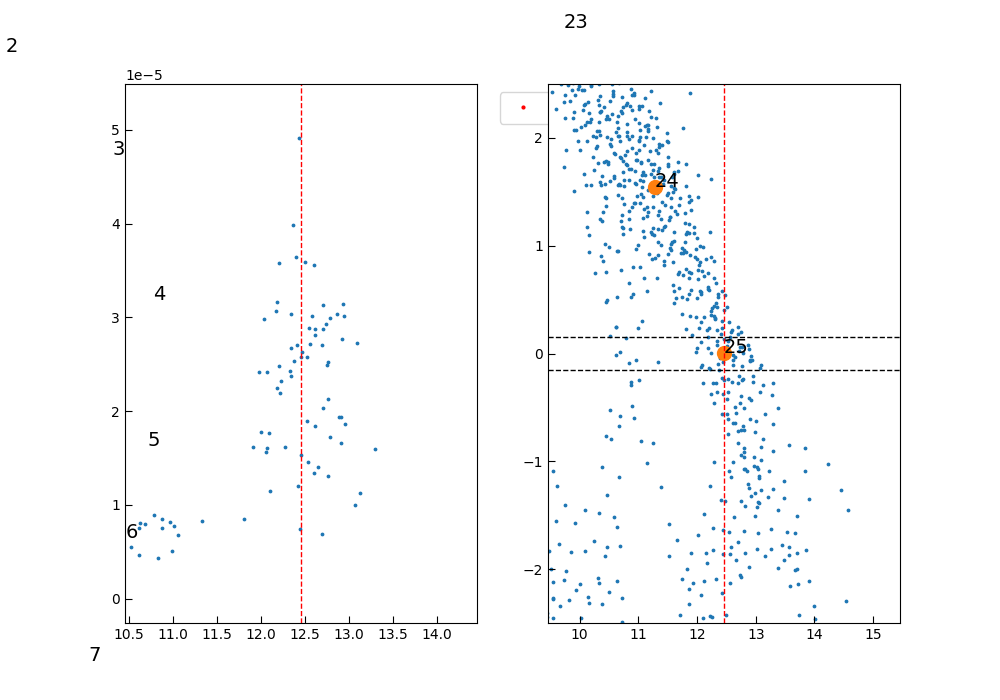

In [530]:
n= 25  #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [531]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [532]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(7.76294969669323e-13, 3.448693364689925e-05)

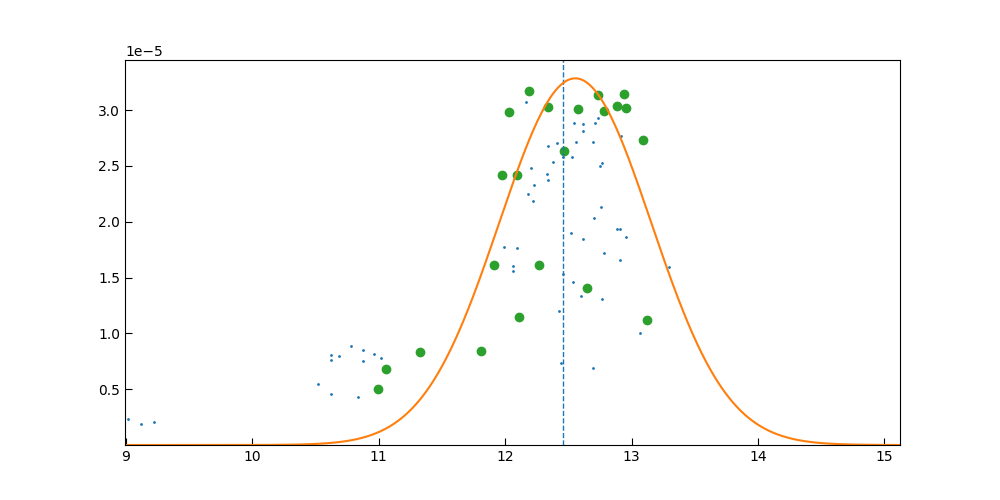

In [533]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [534]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [535]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000012,2.708450,0.05,False,-2.897497,0.0,0.411402,8.693027e-07,0.021994,1.544260,0.041397,"[1.5527010886672423, 1.591412618745411, 1.7299...",2.532468,"[1.726008130602706e-06, 7.872130896135646e-07,...",-0.611472
1,0.000014,2.416738,0.05,False,1.448791,1.0,0.520256,1.042213e-06,0.119084,1.127943,0.120114,"[2.1141490788383095, 2.1965449812065927, 2.244...",2.070707,"[6.282016359325803e-06, 7.187771204181052e-06,...",-1.708153
2,0.000021,2.616503,0.05,False,3.564727,2.0,0.493153,1.674766e-06,0.034669,1.587774,0.060571,"[2.384220426080411, 2.4480923083581936, 2.4928...",0.569986,"[4.817721435256505e-06, 8.130913256919182e-06,...",-2.747114
3,0.000028,2.459819,0.05,False,9.366087,3.0,1.139568,1.985699e-06,0.026092,4.056319,0.123933,"[2.3981618426268545, 2.4219235793559752, 2.498...",-1.450216,"[6.521967326316875e-06, 6.687747592436729e-06,...",-2.343074
4,0.000021,3.023343,0.05,False,-1.597062,4.0,0.378226,1.643474e-06,0.097818,1.667673,0.134927,"[2.4812096467005915, 2.5377261164519673, 2.584...",-2.489177,"[1.3846245271967822e-05, 1.8228511345432433e-0...",-1.246392
5,0.000031,3.228970,0.05,False,-3.899095,5.0,0.737389,2.466026e-06,0.037225,2.190174,0.109768,"[2.2332700743788574, 2.2411678477623, 2.319825...",-2.777778,"[1.1413987471045312e-05, 8.661215134661095e-06...",0.081169
6,0.000031,2.407776,0.05,False,4.979274,6.0,0.596533,1.245851e-06,0.016670,1.274181,0.034377,"[2.2727974954225307, 2.408918116321751, 2.4587...",-2.662338,"[3.652160726031116e-06, 2.4854840424483918e-05...",1.004690
7,0.000040,2.839770,0.05,False,23.625737,7.0,1.397990,4.130055e-06,0.023410,17.498137,0.198909,"[2.7993319593067545, 2.8444925278409388, 2.877...",-2.373737,"[1.0632477201212887e-05, 1.054744595592633e-05...",2.274531
8,0.000035,2.927822,0.05,False,2.537329,8.0,1.100390,2.361174e-06,0.089358,1.471219,0.167419,"[2.7734854037846266, 2.789230905594245, 2.8826...",-1.392496,"[1.1348032264475805e-05, 9.882109169809467e-06...",3.140332
9,0.000030,4.839714,0.05,False,-1.043928,9.0,0.657878,1.580652e-06,0.214713,0.947503,0.169998,"[3.1844933902909514, 3.3330812096960645, 3.378...",0.165945,"[2.97988664488054e-06, 7.17232377148717e-06, 5...",3.832973


In [536]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 4.94741e-05
center                                                         12.555
delta                                                            0.05
fractured                                                       False
gamma                                                    -0.000582528
id_tracing                                                         25
sigma                                                        0.600929
stderr_amplitude                                          8.51113e-06
stderr_center                                                 30948.7
stderr_gamma                                                  64550.2
stderr_sigma                                                  136.906
x                   [10.993446105246349, 11.059463735411542, 11.32...
x_tracing                                                    -11.9553
y                   [5.051148525056788e-06, 6.817175390383998e-06,...
y_tracing           

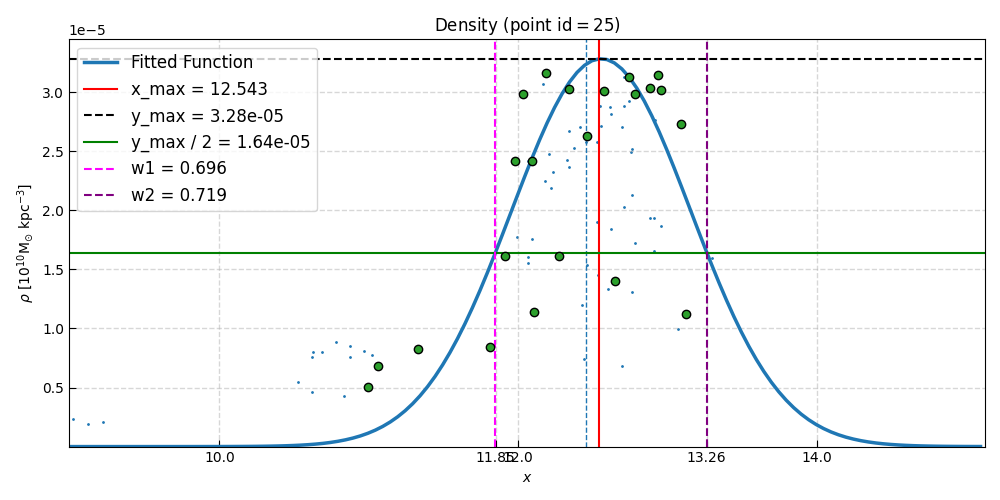

In [537]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

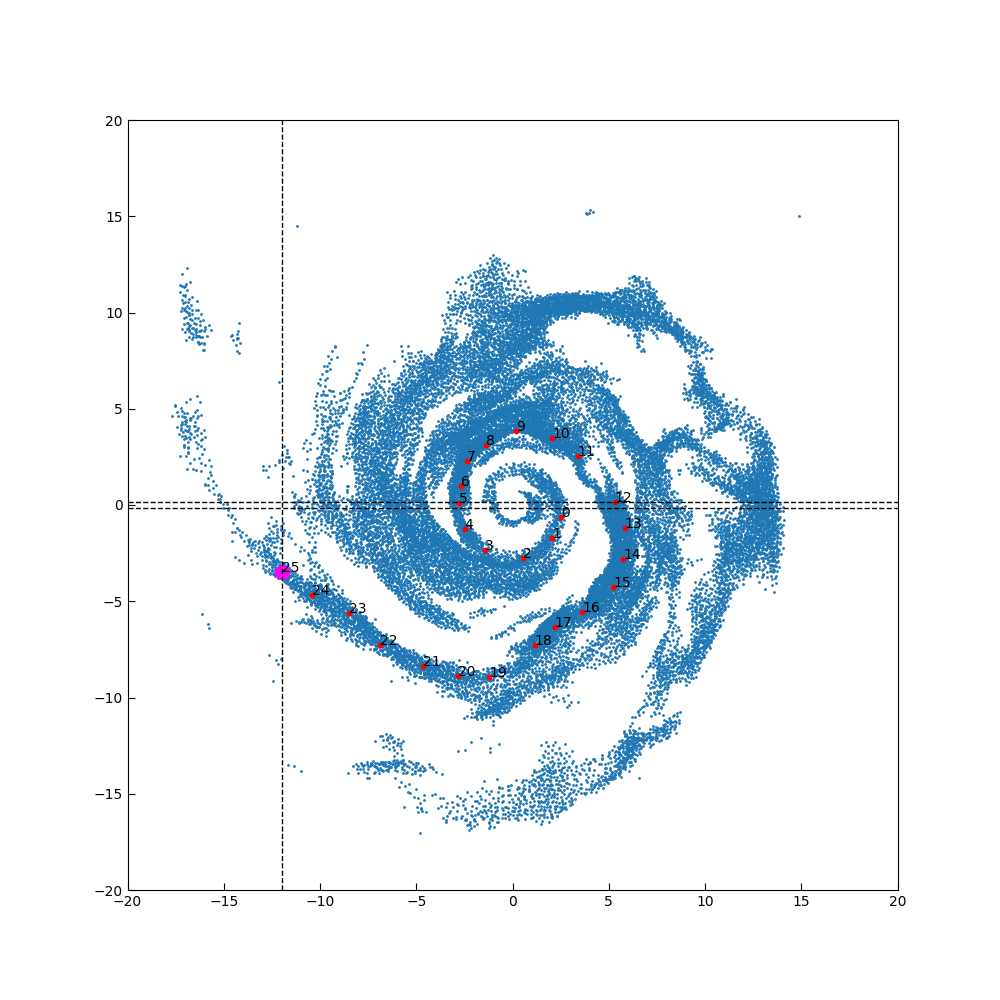

In [538]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [539]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')